<a href="https://colab.research.google.com/github/takatakamanbou/MVA/blob/2023/ex13notebookA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVA2023 ex13notebookA

<img width=64 src="https://www-tlab.math.ryukoku.ac.jp/~takataka/course/MVA/MVA-logo15.png"> https://www-tlab.math.ryukoku.ac.jp/wiki/?MVA/2023

In [1]:
# いつものいろいろインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
seaborn.set()

# Python の統計ツール statsmodels の時系列解析のためのほげ
from statsmodels import tsa
from statsmodels.tsa import seasonal, ar_model
from statsmodels.graphics import tsaplots
from statsmodels.datasets import sunspots, get_rdataset

---
## 時系列解析入門
---



---
### 時系列とは，時系列解析とは


「時々刻々変化する気温」のように，時間の経過にともなって変化する何らかの値を記録して得られるデータを **時系列** (time series) といいます．時系列としては，変数である時間を連続量とするものも考えられますが，ここでは，時間は適当な間隔で離散的に刻まれており（注1），

$$
\ldots, x_{t-3}, x_{t-2}, x_{t-1}, x_{t}, x_{t+1}, x_{t+2}, x_{t+3}, \ldots
$$

のように整数の添字を付けて表せるものを考えます．各値 $x_t$ は実数とします（注2）．添字 $t$ が時刻に対応しており，$t$ が大きい方が未来です．時点 $t$ と時点 $t+1$ の間に実際にはどの位の時間差があるかは，問題設定次第です（1秒だったり1年だったり $\frac{1}{44100}$ 秒だったり（注3））．「月ごとのアイスの売上」のように，間隔が一定でない（この場合は28,29,30,31日）時系列もあり得ます．

<span style="font-size: 75%">
※注1: 連続に変化する変数から適当な間隔で値を取得して離散的な変数にする手続きを「標本化」といいます．この notebook の後半で説明します．</br>
※注2: 値が複素数のものや，1変量でない時系列（多変量時系列）も当然考えられますが，ここでは説明を省きます．</br>
※注3: この 44100 という数字が気になるひとはウェブで検索してみるとよいでしょう．
</span>

**時系列解析** (time series analysis) とは，このような時系列データを確率・統計の道具を使って解析する手法です．過去の時系列データからその変動の傾向や周期性などの特徴をとらえたり，モデル化して未来の値を予測したりすることを目的とします．

#### データ1: 大津市の気温



時系列データの一例として，大津市の平均気温のデータを示します．



In [2]:
# 大津市の気温
URL = 'https://www-tlab.math.ryukoku.ac.jp/~takataka/course/MVA/tempOtsu.csv'
dfOtsu = pd.read_csv(URL, index_col=0, parse_dates=True)
dfOtsu.index.freq = 'MS' # 月毎（1日）
#dfOtsu

これは，気象庁の「過去の気象データ検索」のページ https://www.data.jma.go.jp/obd/stats/etrn/index.php で条件を指定して入手した CSV ファイルを加工したものです．2000年1月から2022年12月までの毎月の平均気温，最高気温，最低気温がありますが，以下では平均気温のみ使います．

In [3]:
X_otsu = dfOtsu['平均気温']
dfOtsu

,平均気温,最高気温,最低気温
2000-01-01,4.7,13.3,-2.5
2000-02-01,2.6,11.4,-2.5
2000-03-01,6.2,17.2,-2.7
2000-04-01,12.1,21.4,1.8
2000-05-01,18.7,28.9,7.4
...,...,...,...
2022-08-01,27.9,36.5,18.9
2022-09-01,24.9,34.3,15.3
2022-10-01,17.1,29.3,6.9
2022-11-01,13.0,23.1,5.0


各行に月初めの日付が入っていますが，これはデータ作成の都合でそうなっているだけです．実際の値はその月の平均気温です．
グラフを描くと次のようになります．横軸が日付になっています．

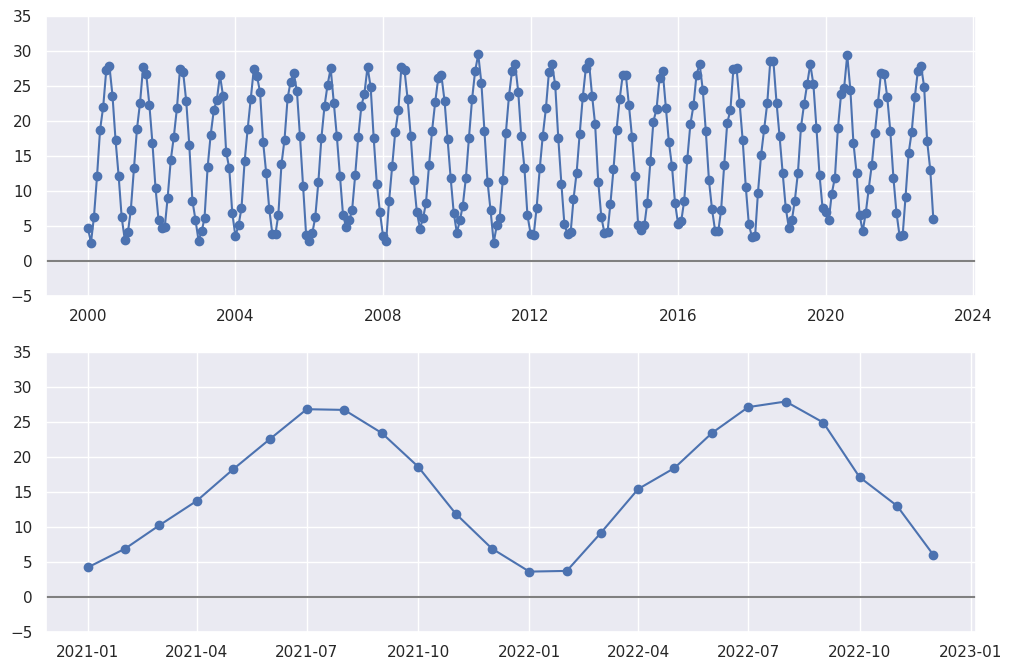

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(X_otsu, '-o')
ax[0].axhline(0, color='gray')
ax[0].set_ylim(-5, 35)
ax[1].plot(X_otsu['2021-01':'2022-12'], '-o')
ax[1].axhline(0, color='gray')
ax[1].set_ylim(-5, 35)
plt.show()

#### データ2: 太陽の黒点数

太陽の黒点の数は，400年以上も昔から観測データが蓄積されています（参考: [Wikipediaの太陽黒点の記事](https://ja.wikipedia.org/wiki/%E5%A4%AA%E9%99%BD%E9%BB%92%E7%82%B9)）．

ここでは，Python 用の統計ツール [statsmodels](https://www.statsmodels.org/) が提供している1700年から2008年までのデータを利用します．

In [5]:
# 1700年から2008年までの毎年の太陽黒点数
dfSun = sunspots.load_pandas().data
assert dfSun['YEAR'].min() == 1700 and dfSun['YEAR'].max() == 2008
dfSun.index = pd.Index(pd.date_range('1700', end='2008', freq='AS'))
dfSun.drop(columns='YEAR', inplace=True)
X_sun = dfSun['SUNACTIVITY']
dfSun

,SUNACTIVITY
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
2004-01-01,40.4
2005-01-01,29.8
2006-01-01,15.2
2007-01-01,7.5


各行に年始の日付が入っていますが，これはデータ作成の都合でそうなっているだけです．各行の値はその年に観測された黒点の数です．黒点数は，太陽の活動と関連しておよそ11年ほどの周期で増減していることが知られています．

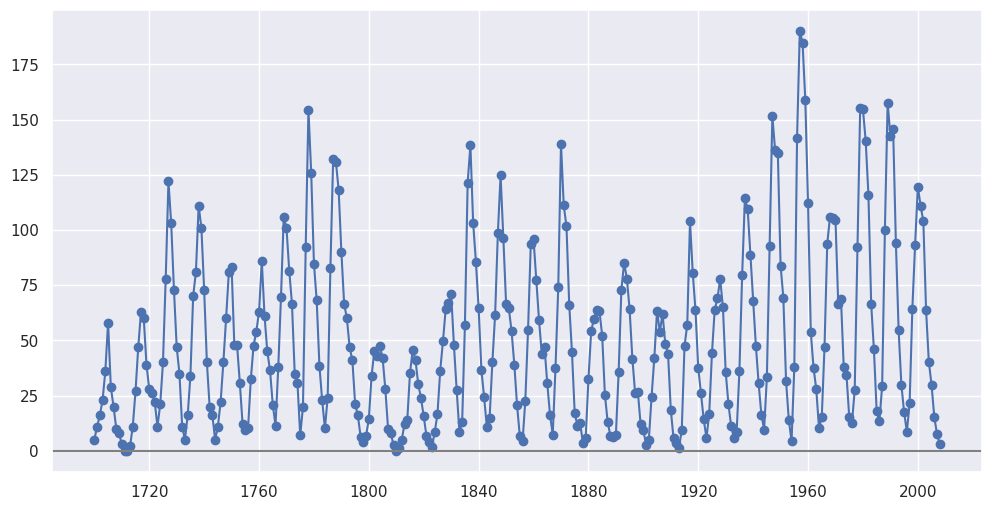

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X_sun, '-o')
ax.axhline(0, color='gray')
plt.show()

#### ［よだんだよん］pandas の時系列データの扱い

この notebook では，Python 用のデータ分析ツール [pandas](https://pandas.pydata.org/) を使って時系列データを取り扱っています．pandas には時系列を扱うのに便利なデータ型や機能がたくさんあります．普通の配列だったら要素番号を使うしかないところで，日付や時刻を表す記法を使ったりできます．例えばデータ1の場合，

In [7]:
# 要素番号でのアクセス
print(dfOtsu.iloc[100, :])
print()
# 日付でのアクセス
print(dfOtsu.loc['2022-12', :])

平均気温    18.4
最高気温    30.1
最低気温     7.6
Name: 2008-05-01 00:00:00, dtype: float64

            平均気温  最高気温  最低気温
2022-12-01   6.0  14.8  -1.5


In [8]:
# 日付や時刻の文字列でスライスすることもできる
dfOtsu['2022':'2022-06']

,平均気温,最高気温,最低気温
2022-01-01,3.6,12.9,-1.9
2022-02-01,3.7,15.2,-2.0
2022-03-01,9.1,21.8,-1.3
2022-04-01,15.4,27.6,1.5
2022-05-01,18.4,30.3,6.5
2022-06-01,23.4,35.7,12.3


---
### 時系列データの基本統計量

#### 平均，分散，自己共分散，自己相関

時系列データは，一般的なデータの分析の場合と同様に，**平均** (mean)（または **期待値** (expected value)） や **分散** (variance) といった基本的な統計量によって要約することができます．以降では，$x_t$ の平均を $\mu_{t} = \textrm{E}[x_t]$ と表し，分散を $ \textrm{Var}[x_t] = \textrm{E}[(x_t-\mu_t)^2]$ と表します．平均も分散も，$t$が変われば変わり得ることに注意してください（後述の定常性の項参照）．

一方，時系列データに特有の統計量として，**自己共分散** (autocovariance) と **自己相関** (autocorrelation) と呼ばれるものがあります．自己共分散は，次式で定義されます．

$$
\textrm{Cov}[x_t, x_{t-k}] = \textrm{E}[(x_t-\mu_t)(x_{t-k}-\mu_{t-k})] \qquad (1)
$$

ただし，$\mu_{t-k} = \textrm{E}[x_{t-k}]$ です．一般的な共分散は異なる2つの変数間の関係を表す量でしたが，自己共分散は，$x_t$ と，そこから $k$ 時点離れた値 $x_{t-k}$ との間の関係を表します．ここで，時間差を表す $k$ のことを **ラグ** (lag) といいます．ラグが $0$ すなわち $k=0$ のときの自己共分散は分散と一致します．

例えば，ある場所の日毎の平均気温の時系列データがあったとすると，時点 $t$ の気温 $x_t$ が平均より高いときは $x_{t-1}$（その前日の気温）や $x_{t-2}$ （前々日の気温）もおそらく平均より高い傾向にあり，逆に $x_t$ が平均より低いときは $x_{t-1}$ や $x_{t-2}$ も低い傾向にあるでしょう．そのような場合，ラグ $k=1$ や $k=2$ での自己共分散の値は正となります．もしも逆の傾向（気温が平均より高かった/低かった翌日は気温が平均より低く/高くなりがち）があったならばこの値は負となり，無関係ならば $0$ に近い値となります．



自己共分散が一般的な共分散に対応しているのに対して，自己相関は相関係数に対応しており，次式で定義されます．

$$
\textrm{Corr}[x_t, x_{t-k}] = \frac{\textrm{Cov}[x_t, x_{t-k}]}{\sqrt{\textrm{Var}[x_t] \textrm{Var}[x_{t-k}]}} \qquad (2)
$$

一般的な相関係数と同様に，自己相関は $-1$ 以上 $1$ 以下の値をとります．また，式から明らかなように，$k=0$ では $1$ となります．

#### 時系列の定常性

ここまで時系列の性質について何も仮定を置かずに来ましたが，時系列解析の手法によっては，対象とする時系列が特定の条件を満たしていることを前提とする場合があります．そのような条件の代表が，**定常性** (stationarity)と呼ばれるものです．



定常性には， **弱定常性** (weak stationarity) と **強定常性** (strong stationarity) という二つがあります．弱定常性の条件は次の通りです（強定常性についてはこの授業では省略します）．

- 平均 $\textrm{E}[x_t]$ が $t$ によらず一定（ここでは $\textrm{E}[x_t] = \mu$ と表記する）
- 分散 $\textrm{Var}[x_t]$ が $t$ によらず一定
- 自己共分散 $\textrm{Cov}[x_t, x_{t-k}]$ が $t$ によらず，ラグ $k$ のみに依存する．
$\textrm{Cov}[x_t, x_{t-k}] = \textrm{E}[(x_t-\mu)(x_{t-k}-\mu)]
$

弱定常性を満たす時系列では，自己相関も自己共分散と同じように ラグ $k$ のみで決まります．

#### 自己相関と周期性

弱定常性を満たす時系列の自己相関の値は，ラグ $k$ のみで決まります．時系列データに周期性があり，ほぼ一定の変動パターンを繰り返すようなものだった場合，$k$ がその周期に一致したとき（およびその2倍,3倍,...,のとき）に $x_t$ と $x_{t-k}$ が近い値をとり，自己相関の値が大きくなります．
このような性質がありますので，自己相関を求めることで，時系列がどのような周期を持つかを調べることができます．

次のグラフは，データ1とデータ2のそれぞれで求めた自己相関の値を描いたものです．
Python 用の統計ツール [statsmodels](https://www.statsmodels.org/) の機能を利用しています
（cf. [statsmodels.graphics.tsaplots.plot_acf](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html)）．

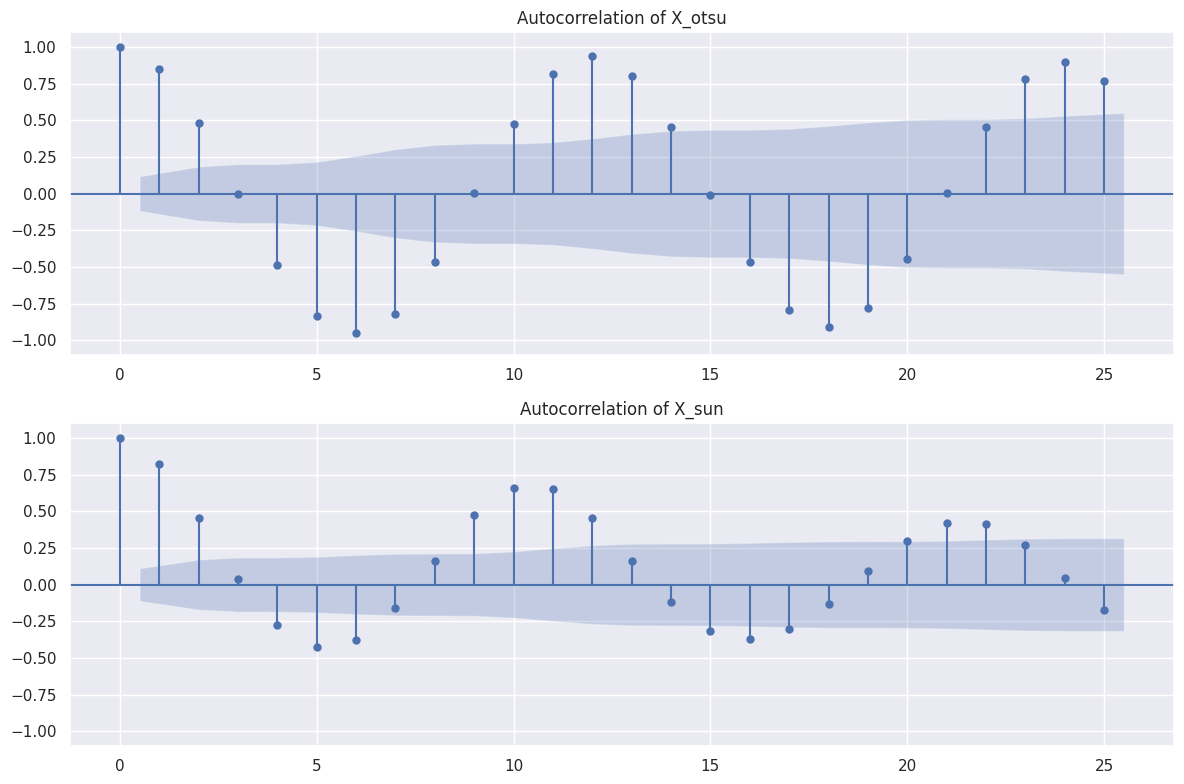

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
tsaplots.plot_acf(X_otsu, ax=ax[0], title='Autocorrelation of X_otsu')
ax[0].set_ylim(-1.1, 1.1)
tsaplots.plot_acf(X_sun, ax=ax[1], title='Autocorrelation of X_sun')
ax[1].set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

横軸がラグ $k$ で縦軸がそのラグでの自己相関の値 $\textrm{Corr}[x_t, x_{t-k}]$ です（注）．

<span style="font-size: 75%">
※注: 青い帯は，自己相関の値の95%信頼区間を表しています．点がその外にあれば，そのラグで無相関であるという帰無仮説を有意水準5%で棄却できます（＝相関がないとは言えない）．
</span>

気温の方は，$k=12$ で自己相関の値が $1$ に近くなっており，明らかに周期12ヶ月で変動していることが分かります．$k=6$ で自己相関の値が $-1$ に近いのは，6ヶ月ずれるとちょうど季節が反対になるためです．

太陽黒点数の方は，$k=10,11$ で正の相関があり，10年から11年程度の周期で変動していることが示唆されます．

---
### 時系列の前処理

時系列データは，そのままでは扱いづらかったり定常性の条件を満たさなかったりするため，扱いやすくするために適当な処理を施してから解析することがあります．
ここでは，そのような「前処理」の代表例を紹介します．


#### データ3: 大津市の2004年の日平均気温

In [10]:
# 大津市の2004年の日平均気温
URL = 'https://www-tlab.math.ryukoku.ac.jp/~takataka/course/MVA/temp2004.txt'
df2004 = pd.read_csv(URL, names=['temp'])
X_2004 = df2004['temp']
#df2004

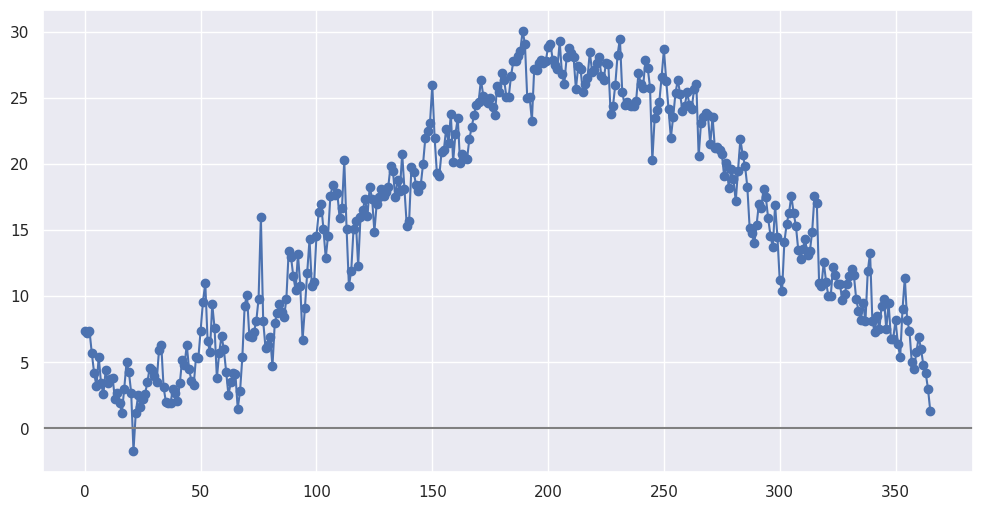

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X_2004, '-o')
ax.axhline(0, color='gray')
plt.show()

#### 平滑化

データ3は毎日の平均気温の値から成る時系列の例です．日ごとの気温変動が分かる一方で，そのような短い時間間隔での変動を含むためにかえって長いスパンでの変動の傾向が読み取りづらくなっています．
このようなデータの場合，以下で説明する **平滑化**（スムージング, smoothing）を行うことで，短周期の変動成分を捨てて，より長い周期の変動成分に注目することが可能となります．


最も簡単な平滑化の方法は，元の時系列の各時点の値 $x_t$ とそれ以前のいくつかの値 $x_{t-1}, x_{t-2},\ldots$ の平均をとったものを新しい時系列とする，というものです．
元の時系列の時点 $t$ から $t-1, t-2, \ldots, t-(K-1)$ までの $K$ 個の値の平均をとる場合，新しい時系列の値 $y_t$ は次式で求められます．

$$
y_t = \frac{1}{K}\sum_{k=0}^{K-1}x_{t-k} \qquad (3)
$$

具体例を示します．

[ 0 -2  0 -4 10 12 10 12  8  5  4  3 -2  0  2  0]


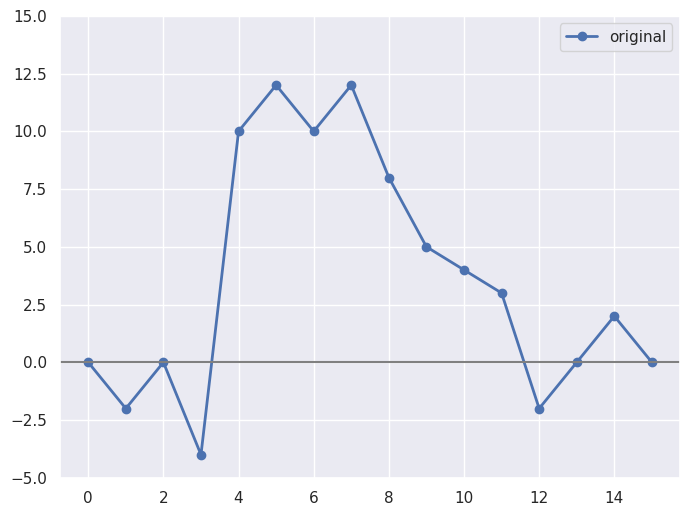

In [12]:
f = np.array([0, -2, 0, -4, 10, 12, 10, 12, 8, 5, 4, 3, -2, 0, 2, 0])
print(f)
df = pd.DataFrame(f, columns=['original'])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['original'], '-o', lw=2, label='original')
ax.axhline(0, color='gray')
ax.set_ylim(-5, 15)
ax.legend()
plt.show()

このような16点から成る時系列を $\{ x_t \}$ として，$K=2, 4, 6$ の場合に式$(3)$の計算を行うと，$\{ y_t \}$ は次のようになります．自分でコードを書いても大したことはありませんが，ここでは Python 用のデータ分析ツール [pandas](https://pandas.pydata.org/) の [pandas.DaraFrame.rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) を用いています．

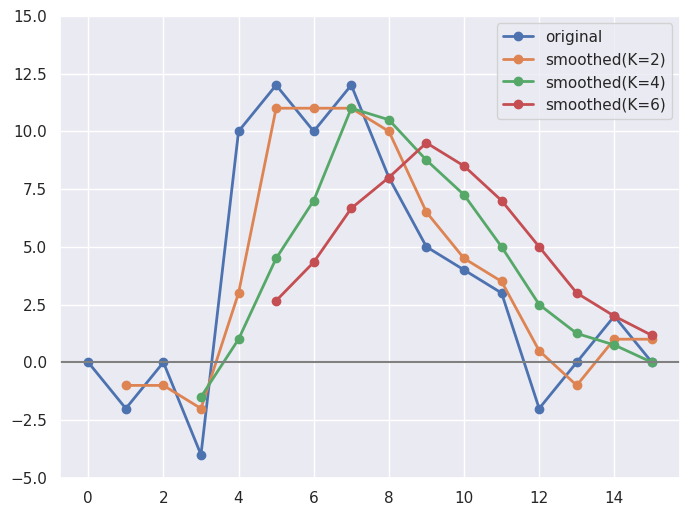

,original,smoothed(K=2),smoothed(K=4),smoothed(K=6)
0,0,NaN,NaN,NaN
1,-2,-1.0,NaN,NaN
2,0,-1.0,NaN,NaN
3,-4,-2.0,-1.50,NaN
4,10,3.0,1.00,NaN
5,12,11.0,4.50,2.666667
6,10,11.0,7.00,4.333333
7,12,11.0,11.00,6.666667
8,8,10.0,10.50,8.000000
9,5,6.5,8.75,9.500000


In [13]:
Klist = [2, 4, 6]
for K in Klist:
    # 窓サイズ K での移動平均
    df[f'smoothed(K={K})'] = df['original'].rolling(window=K).mean()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['original'], '-o', lw=2, label='original')
for K in Klist:
    key = f'smoothed(K={K})'
    ax.plot(df[key], '-o', lw=2, label=key)
ax.axhline(0, color='gray')
ax.set_ylim(-5, 15)
ax.legend()
plt.show()

df

これらのグラフと表では，`original` が $x_t$ を表し，`smoothed(K=2)` が $K=2$ で平滑化した時系列 $y_t$ を表します．`smoothed(K=4)` と`smoothed(K=6)` も同様です．

表の方を見ると，例えば，$K=2$ の場合 $x_2 = 0, x_3 = -4$ より $y_3 = (x_3 + x_2)/2 = -2$ となり，
$K=4$ の場合 $y_3 = (x_3 + x_2 + x_1 + x_0)/4 = -1.5$ となっています．時系列の値が存在しないため計算できないところは `NaN` （Not a Number の意）と表記されています．

グラフの方を見ると，$K$ を大きくすると短時間での変動成分が失われ，より長いスパンでの変動成分のみが残されていることが分かるでしょう．

以下に，データ3に平滑化を適用した結果を示します．

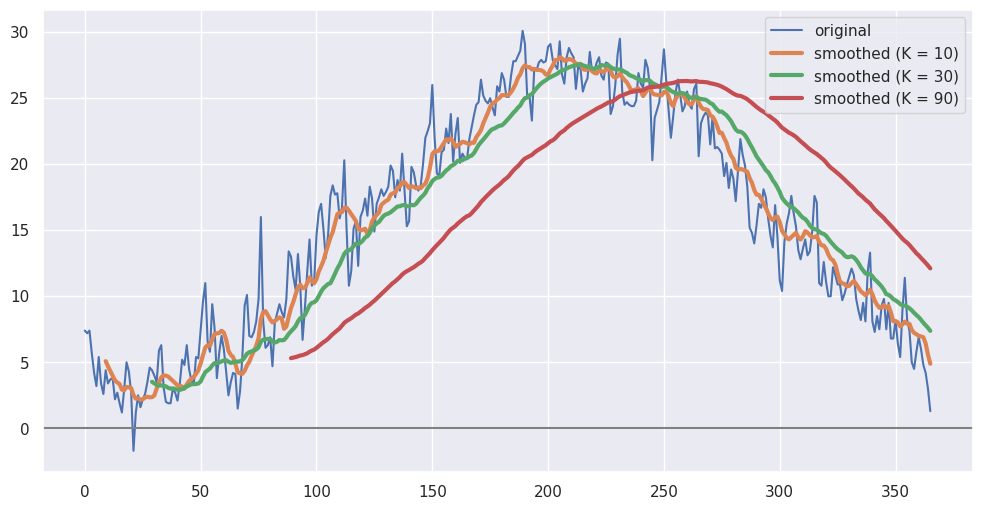

In [14]:
# 平滑化（後方移動平均）
fig, ax = plt.subplots(figsize=(12, 6))
Klist = [10, 30, 90]
ax.plot(X_2004, '-', label='original')
for K in Klist:
    Y = X_2004.rolling(window=K).mean()
    ax.plot(Y, '-', lw=3, label=f'smoothed (K = {K})')
ax.axhline(0, color='gray')
ax.legend()
plt.show()

やはり，$K$ を大きくするほど短時間での変動成分を捨てられて，長期の変動の傾向を読み取りやすくなっています．

式 $(3)$ では，$y_t$ の値は，$x_t$ から $x_{t-(K-1)}$ までの過去 $K$ 点の値の平均として算出されます．そのため，$K$ が大きくなると，元の時系列と比べて変化の遅れが目立つようになります．
これを避けるために，「時点 $t$ およびそれ以前の $K$点の平均」の代わりに「時点 $t$ の前後の $K$ 点の平均」を使う平滑化のやり方もあります．

以下に，データ3にそのような平滑化を適用した結果を示します．




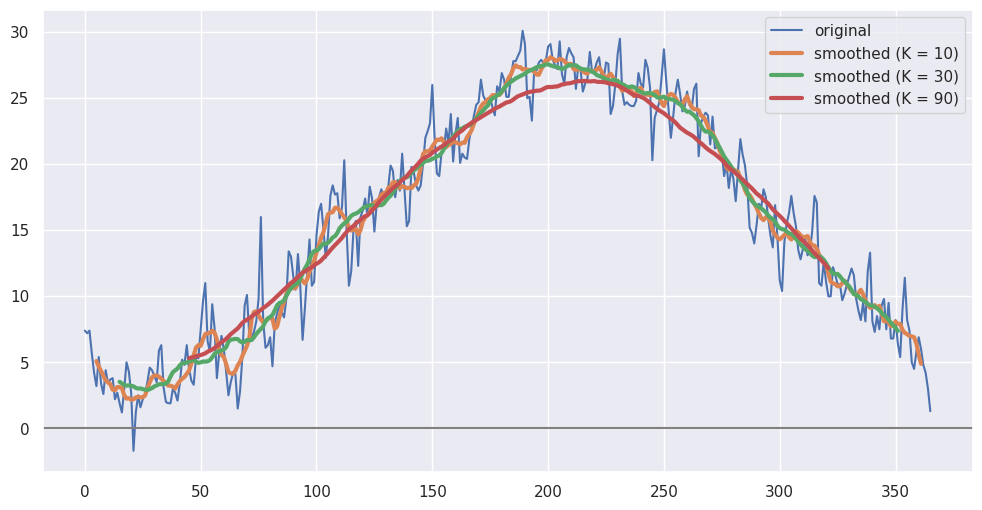

In [15]:
# 平滑化（中心化移動平均）
fig, ax = plt.subplots(figsize=(12, 6))
Klist = [10, 30, 90]
ax.plot(X_2004, '-', label='original')
for K in Klist:
    Y = X_2004.rolling(window=K, center=True).mean()
    ax.plot(Y, '-', lw=3, label=f'smoothed (K = {K})')
ax.axhline(0, color='gray')
ax.legend()
plt.show()

見ての通り，変化の遅れは見られなくなります．しかし，こちらのやり方では，現時点より未来の値を用いて平滑化をすることになりますので，場合によっては適切でないこともあります（例えば過去の値から未来の値を予測したい場合には使えません）．

#### 差分化

平滑化を施すと，短時間の変動成分を捨てて長時間の変動成分に注目することができるのでした．逆に，長時間の変動成分を捨てて短時間の変動成分のみを見たい場合，

$$
y_t = x_t - x_{t-1} \qquad (4)
$$

のように，各時点の値からその直前の値を差し引いた値，すなわち **差分** (difference) を求めてそれを新たな時系列とすることがあります（注）．
定常性を満たさない時系列でも，差分をとることで定常とみなせるようになる場合があります．

<span style="font-size: 75%">
※注: 差分の差分（2階差分）を使ったり，1時点前ではなく2時点以上前の値を差し引く場合もありますが，説明は省略します．
</span>

以下に，平滑化のときと同じデータで差分化の例を示します．差分の計算も自分でコードを書くのは簡単ですが，ここでは [pandas.DaraFrame.diff](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html) を使っています．

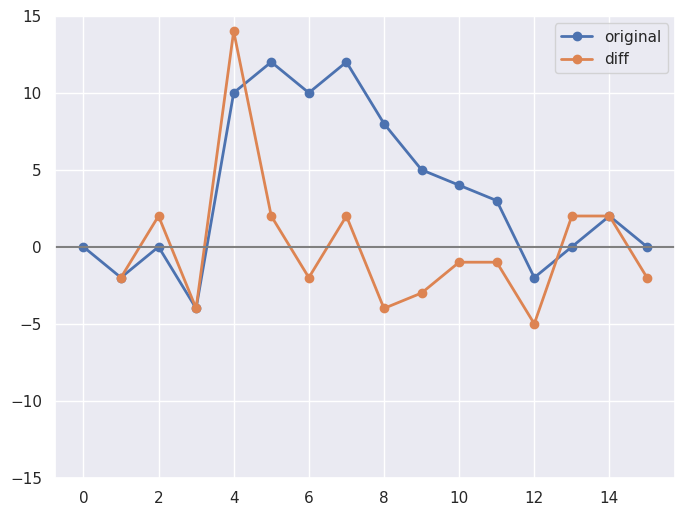

,original,diff
0,0,NaN
1,-2,-2.0
2,0,2.0
3,-4,-4.0
4,10,14.0
5,12,2.0
6,10,-2.0
7,12,2.0
8,8,-4.0
9,5,-3.0


In [16]:
# 差分を求める
df['diff'] = df['original'].diff()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['original'], '-o', lw=2, label='original')
ax.plot(df['diff'], '-o', lw=2, label='diff')
ax.axhline(0, color='gray')
ax.set_ylim(-15, 15)
ax.legend()
plt.show()

df.loc[:, ['original', 'diff']]

差分は，離散版の微分といえます．差分化した時系列の値は，元の時系列の「傾き」を表すと解釈することができます．この例では，$t=3$ から $t=4$ にかけて $x_t$ の値が急に大きくなっているので，$y_4$ が大きな値をとっています．$t=5,6,7$ では $x_t$ はあまり変動していないので $y_t$ は $0$ に近く，$t = 8$ から $t = 12$ にかけて $x_t$ の値がゆるやかに減少しているところでは， $y_t$ は負の値をとっています．

データ3の場合は次のようになります．

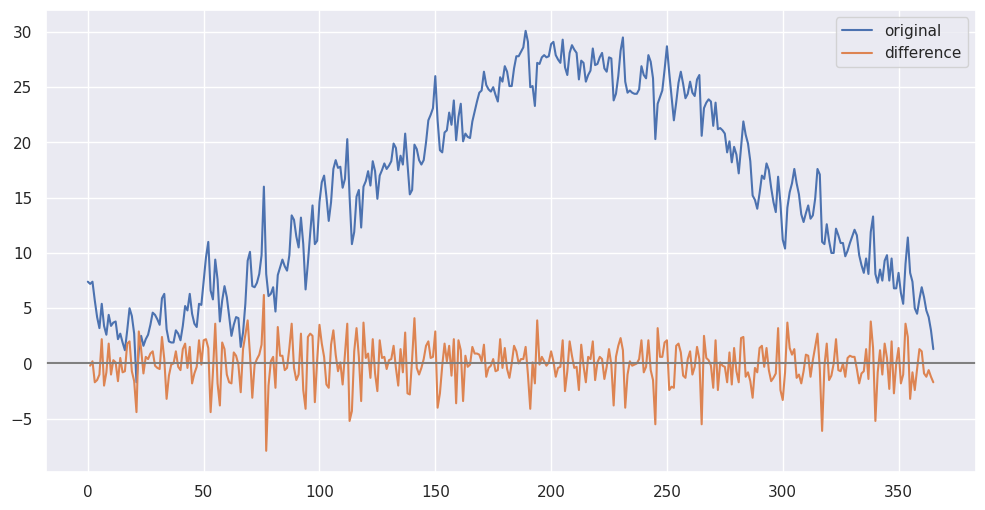

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X_2004, '-', label='original')
ax.plot(X_2004.diff(), '-', label='difference')
ax.axhline(0, color='gray')
ax.legend()
plt.show()

#### 他にも...

時系列の前処理としてよく使われる方法は他にもいろいろあります（ $y_t = \log{x_t}$ とするとか）が，説明は省略します．

---
### 時系列のモデル化と予測

時系列解析の方法の一つに，「モデル化」があります．与えられた時系列の変動を定式化し，その式を解析することで時系列の特徴をとらえようとするものです．モデル化の中には，与えられたデータから未来の時系列を予測することが可能なものもあります．

#### データ4: 航空旅客数


以下では，時系列解析の教科書等によく登場する AirPassengers というデータセットを使って説明をします．
これは，1949年から1960年までの月別の航空旅客数（おそらく米国の，千人単位のもの）です．

In [18]:
# 1949年から1960年までの月別航空旅客数
dfAir = get_rdataset('AirPassengers').data
assert len(dfAir) == 144
dfAir.index = pd.Index(pd.date_range('1949-01', end='1960-12', freq='MS'))
dfAir = dfAir.loc[:, ['value']]
dfAir

,value
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


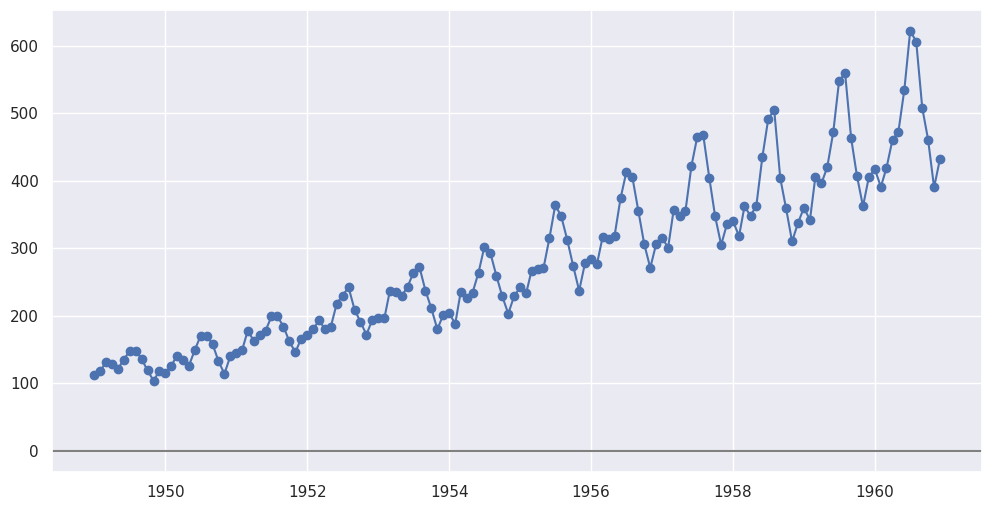

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dfAir, '-o')
ax.axhline(0, color='gray')
plt.show()

#### トレンドや季節変動のモデル化

データ4を見ると，この時系列には，長期的な変動（旅客数が持続的に増加する傾向が見られる）や周期的な変動（おそらく12ヶ月周期で増減している）が含まれていることが分かります．時系列解析においては，対象とする時系列を

- **トレンド**（trend variation, 長期変動，傾向変動）: 長期にわたる変動の成分．
- **季節変動** (seasonal variation): 周期的な変動の成分．12ヶ月周期でないものも慣例的に「季節」変動と呼ばれる．
- **不規則変動** (irregular variation) または **ノイズ** (noise): トレンドと季節変動では表しきれない不規則な変動の成分．

などに分けて解析することがあります．典型的なのは，元の時系列 $x_t$が，トレンド $T_t$，季節変動 $S_t$，不規則変動 $I_t$ の和で表せると仮定する，すなわち

$$
x_t = T_t + S_t + I_t \qquad (5)
$$

というモデルで表す方法です．これを **加法モデル** (additive model) といいます．


statsmodels の機能を使って，データ4を加法モデルで表して3つの変動成分に分解してみましょう．

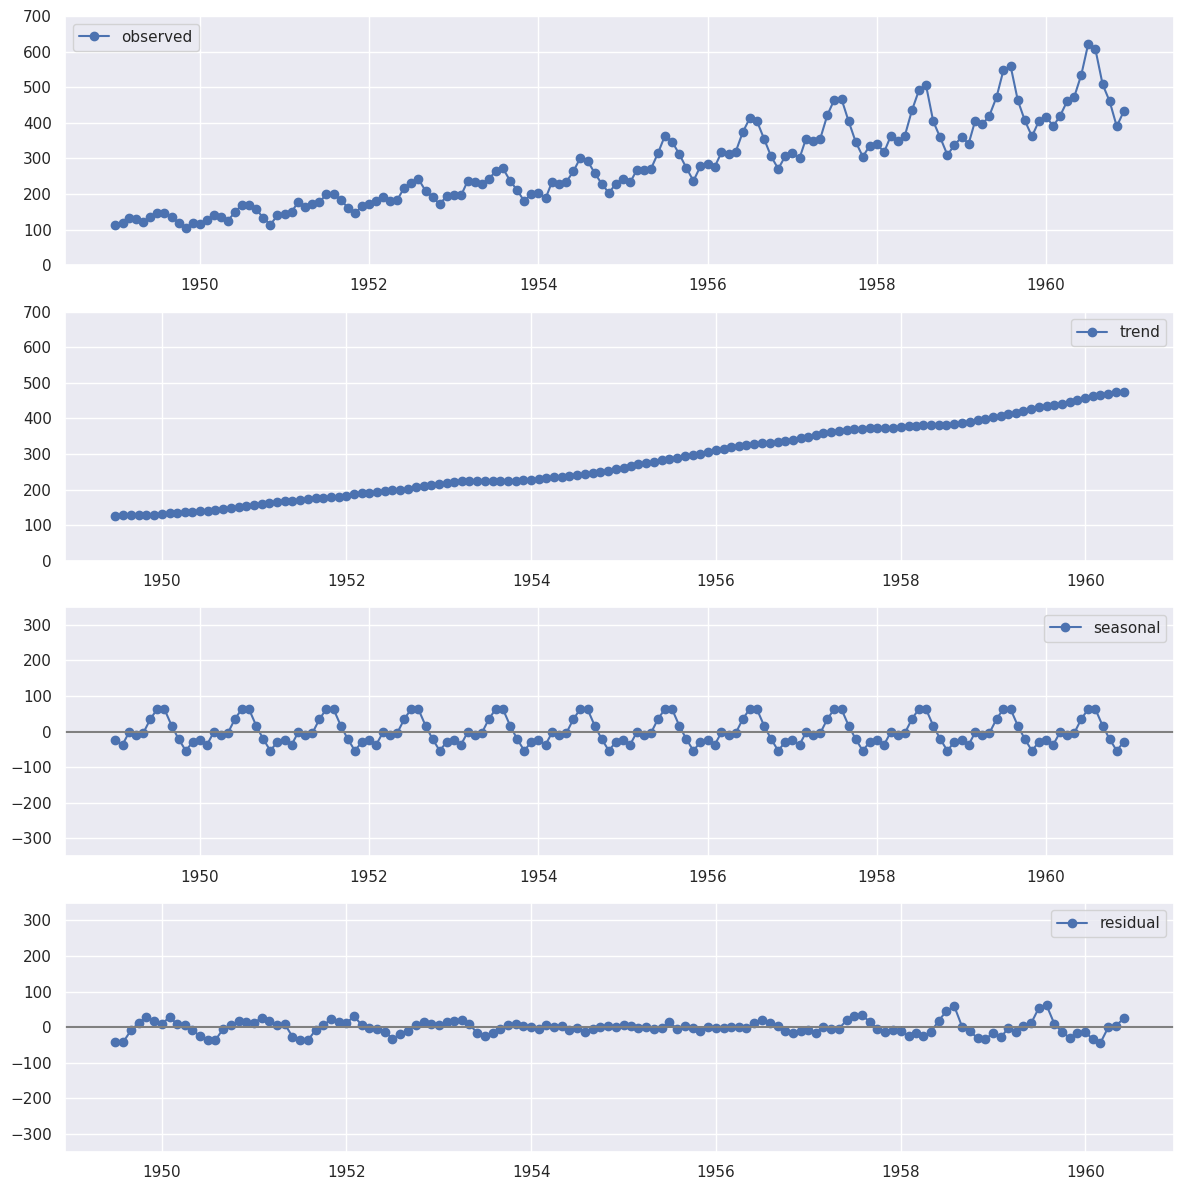

In [20]:
isAdditive = True # True だと加法モデル，False だと乗法モデル

if isAdditive:
    result = seasonal.seasonal_decompose(dfAir, model='additive', period=12, two_sided=True)
else:
    result = seasonal.seasonal_decompose(dfAir, model='multiplicative', period=12, two_sided=True)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax[0].plot(result.observed, '-o', label='observed')
ax[0].set_ylim(0, 700)
ax[0].legend()
ax[1].plot(result.trend, '-o', label='trend')
ax[1].set_ylim(0, 700)
ax[1].legend()
ax[2].plot(result.seasonal, '-o', label='seasonal')
if isAdditive:
    ax[2].set_ylim(-350, 350)
    ax[2].axhline(0, color='gray')
else:
    ax[2].set_ylim(0, 2)
    ax[2].axhline(1, color='gray')
ax[2].legend()
ax[3].plot(result.resid, '-o', label='residual')
if isAdditive:
    ax[3].set_ylim(-350, 350)
    ax[3].axhline(0, color='gray')
else:
    ax[3].set_ylim(0, 2)
    ax[3].axhline(1, color='gray')
ax[3].legend()
plt.tight_layout()
plt.show()

上から順に，元の時系列，トレンド，季節変動，不規則変動，です．変動成分を分解することで，この時系列の特徴がより捉えやすくなっています．

ここでは，各成分を具体的にどのように推定するのか，という詳しい説明は省略します（例えばトレンドは，時系列に直線や多項式を当てはめる回帰や，前節で説明した平滑化を使って推定できます）．

また，加法モデルの代わりに

$$
x_t = T_t \cdot S_t \cdot I_t \qquad (6)
$$

とする **乗法モデル** (multiplicative model) もよく使われます（注）．<font size="-1">白鳥沢 vs 烏野みたいなものですね．</font>

<font size="-1">
※注意: 上記のデータでは，旅客数が増えると季節変動の振幅が大きくなる傾向があり，加法モデルではそれがとらえきれていません（`residual`の左右端に振動が見られる）．このような場合，乗法モデルの方がより適切です（または，同じことですが，元の時系列のそれぞれの値の対数をとった時系列に加法モデルを当てはめる）．上のセルの1行目をコメントに従って修正して実行してみると乗法モデルへの分解もできます．
</font>


#### 自己回帰モデル

時系列をモデル化する方法としては，上記の他にもいろいろあります．ここでは，代表的なモデルである **自己回帰モデル**（**ARモデル**ともいう，autoregressive model）について説明します．

自己回帰モデルは，ある時点の値 $x_t$ を，それ以前の値 $x_{t-1}, x_{t-2}, \ldots $ の線形和で表そうとするものです．
最も単純な自己回帰モデルは，次のように表せます．

$$
x_t = c + wx_{t-1}+ \varepsilon_t \qquad (7)
$$

これは，$x_{t-1}$ を説明変数，$x_{t}$ を被説明変数とするモデルです（直線を当てはめる単回帰とよく似ていますね）．
$c$は定数項，$w$ は $x_t$ に乗ずる係数，$\varepsilon_t$ は，$x_t$ を $c+wx_{t-1}$ で表そうとして表しきれず残った成分（**残差** (residual)と呼ばれます）です．自己回帰モデルでは通常，残差 $\varepsilon_t$ は，弱定常性を持ち平均が $0$ で分散が $\sigma^2$ の時系列であると仮定します（詳しいことは省略しますが，これを **ホワイトノイズ** (white noise)と呼びます）．

上記のモデルでは1時点前の（ラグ$1$の）値のみを説明変数としていますが，ラグ$1$からラグ$K$までの値を説明変数とするように拡張することもできます．この場合，モデルは次のように表せます．

$$
\begin{aligned}
x_t &= c + w_1x_{t-1}+w_2x_{t-2} + \cdots + w_Kx_{t-K} + \varepsilon_t \\
&= c + \sum_{k=1}^{K}w_kx_{t-k} + \varepsilon_t & (8)
\end{aligned}
$$

式$(7)$のモデルが単回帰ならば，こちらは重回帰といえますね．

式$(8)$のモデルの説明変数のラグの最大値は $K$ です．この $K$ のことを自己回帰モデルの「次数(order)」といい，次数が $K$ の自己回帰モデルを「AR($K$)」と表記することがあります．

式$(8)$の自己回帰モデルにおいて推定すべきパラメータは，$c, w_1, w_2, \ldots, w_{K}$ および残差の分散 $\sigma^2$ です．これらは，与えられたデータによく当てはまるように，最小二乗法／最尤推定によって推定されます（計算法の説明は省略します）．

statsmodels の機能を使って，データ1に自己回帰モデルを当てはめて未来を予測させてみましょう（注）．
ここでは，[statsmodels.tsa.ar_model.AutoReg](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html) を使っています．

※注意:

- 自己回帰モデルは，対象とする時系列が弱定常性を持つことを前提とするモデルです．データ1はその条件を満たすとは言えないので，本当は，季節変動を除去したり差分化したりして，より定常に近づけてから扱う方が適切です．しかしここでは，わかりやすさを優先してそのまま扱っています．
- 以下を実行するとたびたび `FutureWarning` という警告が出るかもしれませんが，気にしなくてokです．


In [21]:
X_train = dfOtsu.loc[:'2017-12', '平均気温'] # 2017年12月までの値
X_test  = dfOtsu.loc['2018-01':, '平均気温'] # 2018年1月以降の値

K = 2 # ARモデルの次数

# X_train を使ってモデルパラメータを推定
model = ar_model.AutoReg(X_train, K, old_names=False)
result = model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                   平均気温   No. Observations:                  216
Model:                     AutoReg(2)   Log Likelihood                -435.817
Method:               Conditional MLE   S.D. of innovations              1.854
Date:                Wed, 13 Dec 2023   AIC                            879.635
Time:                        04:38:53   BIC                            893.098
Sample:                    03-01-2000   HQIC                           885.075
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2409      0.275     15.411      0.000       3.702       4.780
平均気温.L1        1.6242      0.030     54.835      0.000       1.566       1.682
平均気温.L2       -0.9017      0.030    -30.536      0.0

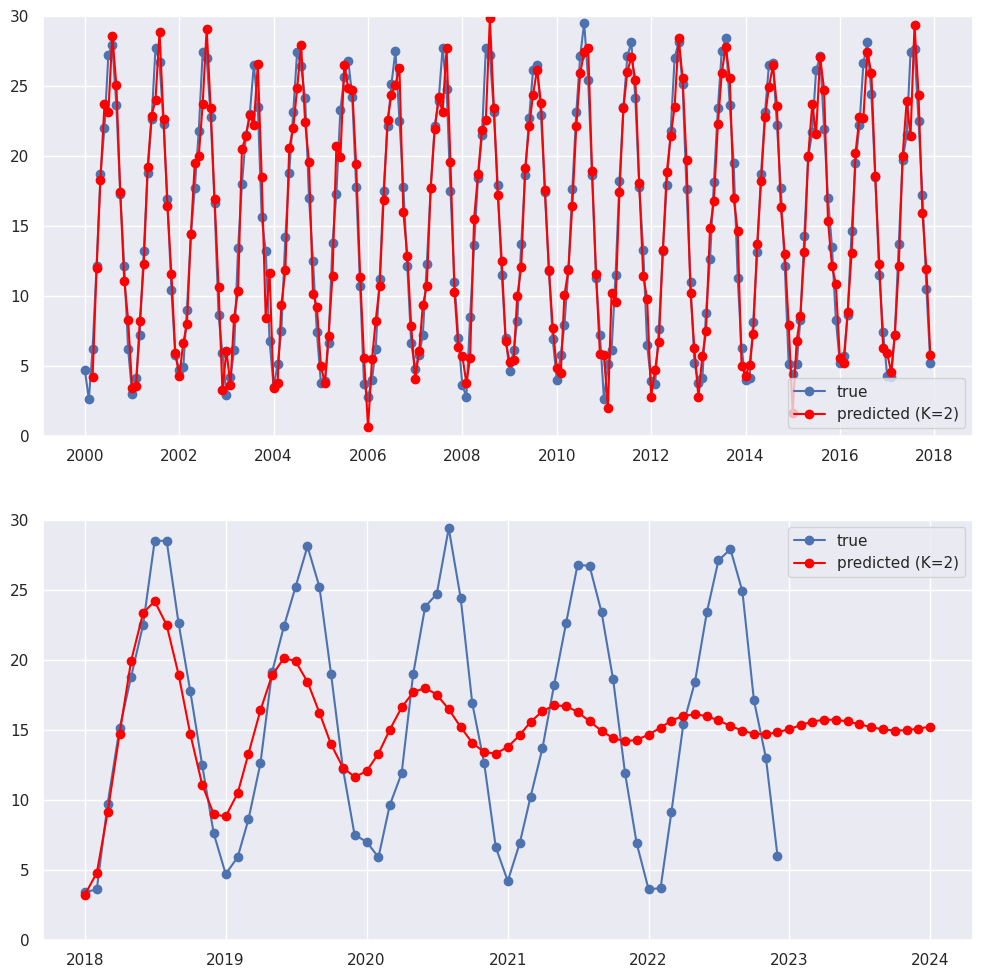

In [22]:
# 得られたモデルを使って予測
X_predicted = result.predict(start='2000', end='2024')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(X_train, '-o', label='true')
ax[0].plot(X_predicted[:'2017-12'], '-o', color='red', label=f'predicted (K={K})')
ax[0].set_ylim(0, 30)
ax[0].legend()
ax[1].plot(X_test, '-o', label='true')
ax[1].plot(X_predicted['2018-01':], '-o', color='red', label=f'predicted (K={K})')
ax[1].set_ylim(0, 30)
ax[1].legend()
plt.show()

例えば `K = 2` として実行したときの出力を見ると，`coef` の `const` が 4.2409 ，「平均気温.L1」が 1.6242，「平均気温.L2」が -0.9017 となっています．これは，このデータに AR(2) モデルを当てはめた結果，

$$
x_t = 4.2409 + 1.6242x_{t-1} - 0.9017x_{t-2} + \varepsilon_t
$$

という式が推定されたことを意味しています．他にもいろんな数値が出力されていますが，説明は省略します．

一方，グラフの方は，上段がモデル当てはめの結果を，下段が得られたモデルを使って未来の時系列の値を予測した結果を描いています．予測値の計算過程を $K=2$ の場合で説明すると，次の通りです．

1. 式$(8)$の $x_{t-2}$ に2017年11月の値を，$x_{t-1}$ に2017年12月の値を代入して，$\varepsilon_t = 0$ とおくと，$x_t$ として2018年1月の予測値が得られる
1. 式$(8)$の $x_{t-2}$ に2017年12月の値を，$x_{t-1}$ に予測した2018年1月の値を代入して，$\varepsilon_t = 0$ とおくと，$x_t$ として2018年2月の予測値が得られる
1. 同様の計算を繰り返して，1時点ずつ未来の予測値を求めていく

このような計算によって長期に渡る予測を行うことができます．

結果を見ると，モデルの次数が小さいと予測がうまくいきませんが，次数をある程度大きくすると，5年先くらいまである程度予測できるようになることが分かります（ではモデルの次数は大きければ大きいほどよいかというと，そんなことはありません．notebookBでその辺りのことを説明します）．

#### 他にも...

時系列のモデルは自己回帰モデルの他にもいろいろありますが，ここでは説明を省略します．


---
### 標本化


この notebook の冒頭で少しだけ触れた「標本化」について説明します．

物理世界を観測して得られる情報は，「時間にともなって変化する気温」のように，時間や空間といった数量にともなって変化する何らかの数量であることが多くあります．
何かの数量の変化にともなって変化する何かの数量において，前者（気温の例における時間を表す量）を「変数」といい，後者（気温）を「値」といいます．

量には，連続なものも離散的な（とびとびの）ものもありますが，コンピュータはディジタルな情報を扱うことしかできませんので，連続な量であっても離散的に表します．
例えば大津市の一地点の気温は，連続な量である時間にともなって変化する連続な量です．しかし，「データ3: 大津市の2004年の日平均気温」では，「1日ごとの平均気温」という値として，時間軸を1日単位で離散化して扱っていました．

データを扱う際には，このように，本来は連続な変数を離散化してから扱うことがよくあります．変数を離散化するこの処理のことを，**標本化** (sampling) といいます．これに対して，値の方を離散化する処理は **量子化** (quantization) といいます（注）．

<span>
※注: 量子化についての説明はこの授業では省略します．データ3 の場合，気温の値は 0.1 度刻みとなっていました．コンピュータで扱う場合は，値を 2 のべき乗通りに離散化する量子化が便利なのでよく用いられます．たとえば一般的な画像ファイルでは画素値を 0 から 255 の 256 段階で表します．
</span>

#### 標本化間隔（標本化周期）と標本化周波数

ここでは，変数を一定の間隔で離散化するような標本化の仕方を考えます．この間隔のことを，**標本化間隔** （または **標本化周期**） といいます．

次のセルをそのまま実行すると，$x(t) = \sin{2\pi t}$ （ $t$ の単位は [s] ）の値を $t = 0, 0.1, 0.2, \ldots$ と標本化間隔 $0.1[s]$ で取り出す標本化を行った結果が表示されます．
灰色の曲線が元の $x(t)$ で，赤い点が標本化によって得られる値です．

標本化間隔は `T` という変数で指定していますので，適当に値を変えて結果を眺めてみましょう．

x = 
[ 0.00000000e+00  5.87785252e-01  9.51056516e-01  9.51056516e-01
  5.87785252e-01  1.22464680e-16 -5.87785252e-01 -9.51056516e-01
 -9.51056516e-01 -5.87785252e-01 -2.44929360e-16  5.87785252e-01
  9.51056516e-01  9.51056516e-01  5.87785252e-01  3.67394040e-16
 -5.87785252e-01 -9.51056516e-01 -9.51056516e-01 -5.87785252e-01] N = 20


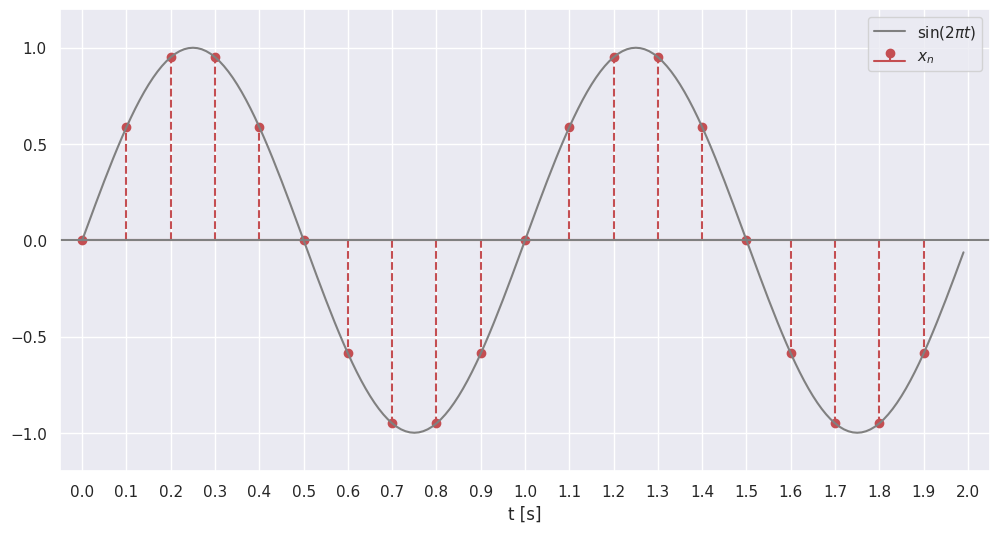

In [23]:
T = 0.1

duration = 2.0

t_sample = np.arange(0, duration, T)
N = len(t_sample)
t = np.arange(0, duration, 0.01)
x_sample = np.sin(2*np.pi*t_sample)
x        = np.sin(2*np.pi*t)

print('x = ')
print(x_sample, f'N = {N}')

fig, ax = plt.subplots(figsize=(12, 6))
ax.stem(t_sample, x_sample, linefmt='r--', markerfmt='ro', label='$x_n$')
ax.plot(t, x, '-', label=f'$\sin(2\pi t)$', color='gray')
ax.set_xlabel('t [s]')
ax.axhline(0, color='gray')
ax.set_xlim(-0.05, 2.05)
ax.set_ylim(-1.2, 1.2)
ax.set_xticks(np.arange(0, duration+0.1, T))
ax.legend()

plt.show()

##### やってみよう


標本化間隔を $0.12, 0.2, 0.3, 0.4, 0.5$ などと変えて結果を観察しよう．

標本化間隔の逆数をとったものを，**標本化周波数** といいます．標本化間隔の単位が [s] の場合，標本化周波数の単位は [Hz] です．標本化間隔が 0.1[s] なら，標本化周波数は 1/0.1 = 10 [Hz] です．標本化の際には，標本化間隔を短く（標本化周波数を高く）しないと，元の波形をちゃんと表せません（注）．

<span>
※注: 「では標本化間隔／標本化周波数はどう決めたらよいのだろう」という疑問が浮かびますが，これに関して，「標本化定理」という定理が知られています．例えば，冒頭に出てきた 44100 という数字は，音楽などを記録する CD の規格（CD-DA）で定められた標本化周波数です．標本化定理と人間の聴覚について理解すると，なぜこんな数字なのかが分かるようになります．
</span>